# Keyrir Strætó of hratt?: Samanburður keyrsluhraðagagna frá Strætó API-inu við hámarkshraðagögn

_**Árni Dagur Guðmundsson**: arni@dagur.eu | Menntaskólinn við Hamrahlíð_

## Inngangur:

### API
Falið í kóða heimasíðu Strætó má finna API (forritaskil) sem geyma ýmsar upplýsingar um staka strætisvagna í rauntíma. Strætó appið notar þetta API meðal annars til að sýna staðsetningu strætisvagna á korti. Ég bjó til einfaldan Python pakka sem kallar á API-ið og spýtir út niðurstöðunum í JSON. Hér fyrir neðan sést niðurstaða einfalds kalls:

In [1]:
from straeto import api
api.getBusPositionsFor(["1"])[0]

{'deviceNumber': 34,
 'route': '1-B',
 'gpsTime': '180512164351',
 'lat': 64.0638616666667,
 'lon': -21.9490166666667,
 'speed': 14.15,
 'heading': 35.63,
 'gpsFix': 2,
 'routeNumber': '1',
 'lastStop': 14001580,
 'nextStop': 14001541,
 'pingCode': 6}

Eins og sést býður API-ið upp á breiddargráðu (_lat_), og lengdargráðu (_lon_). Því er til dæmis hægt að birta staðsetningu allra strætisvagna landsins á kort líkt og svo:

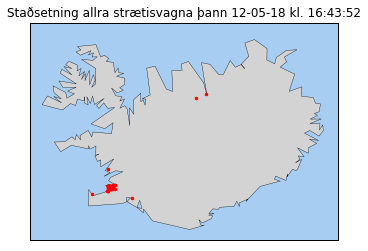

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import warnings; warnings.filterwarnings('ignore')
from datetime import datetime

map = Basemap(projection='merc', resolution='l',
              urcrnrlat=66.8,urcrnrlon=-12.9,
              llcrnrlat=63.2, llcrnrlon=-25)
map.drawcoastlines(linewidth=0.35)
map.fillcontinents(color='lightgrey', lake_color='#a7cdf2')
map.drawmapboundary(fill_color='#a7cdf2')

for bus in api.getAllBusPositions():
    X, Y = map(bus['lon'], bus['lat'])
    map.plot(X, Y, 'ro', markersize=2.5)

plt.title('Staðsetning allra strætisvagna þann {}'.format(datetime.now().strftime('%d-%m-%y kl. %H:%M:%S')))
plt.show()

Hraðinn er einnig til staðar en ekki vitum við þó hvaða mælieining notuð er til þess að mæla hann.

$k\cdot v_{api} = v \Rightarrow k = \frac{v}{v_{api}}$

In [3]:
from straeto import straeto
bdict, p_bdict = straeto.getConsecutiveBuses(ratio=0.5)

print(len(bdict),len(p_bdict))

41 41


In [4]:
from geopy.distance import geodesic
from datetime import datetime as dt
G = []
B = []
Ks = []
for key in bdict:
    bus = bdict[key]; p_bus = p_bdict[key]
    t_1 = dt.strptime(bus['gpsTime'],"%y%m%d%H%M%S"); t_2 = dt.strptime(p_bus['gpsTime'],"%y%m%d%H%M%S")
    delta_t = (t_1-t_2).total_seconds()
    delta_s = geodesic((bus['lat'], bus['lon']), (p_bus['lat'], p_bus['lon'])).km

    kmh = (delta_s/delta_t)*3600
    avg_speed = (1/2)*(bus['speed']+p_bus['speed'])

    k = kmh/avg_speed
    Ks.append(k)
    dic = {
        'speed_0': p_bus['speed'],
        'speed_1': bus['speed'],
        'delta_s': delta_s,
        'delta_t': delta_t,
        'kmh': kmh,
        'avg_speed': avg_speed,
        'route': bus['route'],
        'k': k
    }
    if 1.7 < k < 1.9:
        G.append(dic)
    else:
        B.append(dic)

print('Good:')
for i in G:
    print('{} | k = {} / {} = {} | {} --> {}'.format(
        i['route'], round(i['kmh'], 2), round(i['avg_speed'], 2), round(i['k'], 2), i['speed_0'], i['speed_1']
    ))
print('Bad:')
for i in B:
    print('{} | k = {} / {} = {} | {} --> {}'.format(
        i['route'], round(i['kmh'], 2), round(i['avg_speed'], 2), round(i['k'], 2), i['speed_0'], i['speed_1']
    ))
avg_k = sum(Ks)/len(Ks)
print(avg_k)


Good:
1-B | k = 25.47 / 14.37 = 1.77 | 14.15 --> 14.58
15-D | k = 44.63 / 23.84 = 1.87 | 19.48 --> 28.21
1-E | k = 19.77 / 10.64 = 1.86 | 10.75 --> 10.53
13-B | k = 40.88 / 21.84 = 1.87 | 23.62 --> 20.06
89-A | k = 66.21 / 35.31 = 1.87 | 33.27 --> 37.36
18-C | k = 35.39 / 19.03 = 1.86 | 26.56 --> 11.5
18-B | k = 73.56 / 39.12 = 1.88 | 37.84 --> 40.39
14-A | k = 47.38 / 25.34 = 1.87 | 23.66 --> 27.02
1-C | k = 23.08 / 13.37 = 1.73 | 12.36 --> 14.38
57-A | k = 98.58 / 53.25 = 1.85 | 53.26 --> 53.25
52-A | k = 88.04 / 47.58 = 1.85 | 48.47 --> 46.68
57-B | k = 99.26 / 53.56 = 1.85 | 53.32 --> 53.8
15-B | k = 28.87 / 16.48 = 1.75 | 21.39 --> 11.56
2-C | k = 40.36 / 22.68 = 1.78 | 26.66 --> 18.69
Bad:
11-C | k = 23.36 / 9.48 = 2.47 | 16.62 --> 2.33
51-E | k = 15.14 / 6.02 = 2.51 | 9.42 --> 2.62
12-D | k = 65.92 / 34.3 = 1.92 | 34.81 --> 33.79
15-C | k = 52.77 / 27.44 = 1.92 | 26.69 --> 28.19
2-A | k = 57.17 / 29.98 = 1.91 | 29.28 --> 30.68
4-D | k = 36.2 / 17.54 = 2.06 | 17.37 --> 17.71
28-A

## Undirbúningur gagna:

```
ALTER TABLE buses ADD COLUMN geom Geometry(Point, 4326);
```
svo:
```
UPDATE buses SET geom=ST_SetSrid(ST_MakePoint(lon, lat), 4326);
```

```
SELECT r.maxspeed FROM roads r, buses b WHERE ST_DWithin(b.geom, r.geom, 8) ORDER BY ST_Distance(r.geom, b.geom);
```

In [5]:
!ls

extract_roads  readme.md  straeto  straeto-notebook.ipynb
